In [1]:
import os
import pandas as pd
import numpy as np
import h5py
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///../../../../inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.0f}'.format
format_percent = "{:,.1%}".format

## VMT

In [2]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))
df.index = df.county_name
df.loc['Total',:] = df.sum().values
df = df[['VMT','VHT','delay']]
df

,VMT,VHT,delay
county_name,,,
King,"43,388,501","1,374,624","171,796"
Kitsap,"4,264,333","122,982","2,651"
Outside Region,"334,327","6,410",4
Pierce,"18,669,674","566,253","48,735"
Snohomish,"16,520,513","493,862","44,037"
Total,"83,177,348","2,564,131","267,223"


In [3]:
df = pd.read_csv(os.path.join(valid_config['model_dir'], r'outputs/network/county_network.csv'))

df_obs = pd.read_sql("SELECT * FROM observed_vmt WHERE year="+str(input_config['base_year']), con=conn)
df_obs.rename(columns={'vmt': 'observed'}, inplace=True)

df = df[['county_name','VMT']].merge(df_obs, left_on='county_name', right_on='county')
df.rename(columns={'VMT': 'model'}, inplace=True)
df.index = df['county']
df[['observed','model']] = df[['observed','model']].astype('float')

df.loc['Total',:] = df.sum().values

df['% diff'] = (df['model']-df['observed'])/df['observed']
df[['% diff']] = df[['% diff']].applymap(format_percent)
df[['model','observed','% diff']]

,model,observed,% diff
county,,,
King,"43,388,501","43,820,112",-1.0%
Kitsap,"4,264,333","4,840,030",-11.9%
Pierce,"18,669,674","17,994,803",3.8%
Snohomish,"16,520,513","15,825,794",4.4%
Total,"82,843,022","82,480,739",0.4%


## Daily Traffic Counts

In [4]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
@facilitytype,,,,
Arterial,"13,060,004","13,640,025","580,021",4.4%
Collector,"72,096","86,383","14,287",19.8%
Freeway,"46,455,221","44,470,094","-1,985,127",-4.3%
HOV,"246,053","269,348","23,295",9.5%
Ramp,"334,132","251,017","-83,115",-24.9%
Total,"60,167,506","58,716,867","-1,450,639",-2.4%


In [5]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
county,,,,
King,"32,134,146","31,971,386","-162,760",-0.5%
Kitsap,"3,636,120","2,834,544","-801,576",-22.0%
Pierce,"12,521,558","12,560,058","38,500",0.3%
Snohomish,"11,875,682","11,350,879","-524,803",-4.4%
Total,"60,167,506","58,716,867","-1,450,639",-2.4%


## Daily Traffic Scatterplot

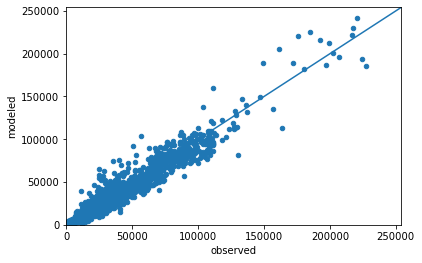

In [6]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [7]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.9595320017049398


King r^2: 0.9601518416989088
Kitsap r^2: 0.9580857095062555
Pierce r^2: 0.9632941127766418
Snohomish r^2: 0.9468261080455748


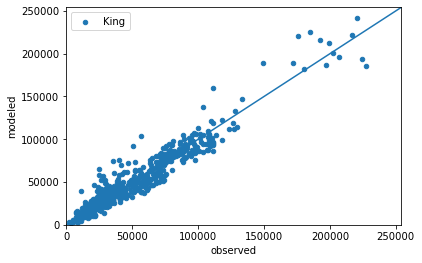

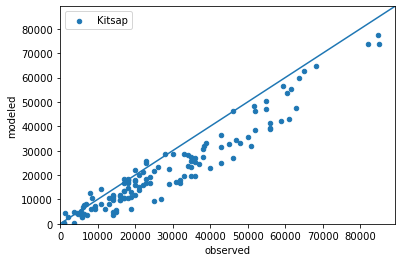

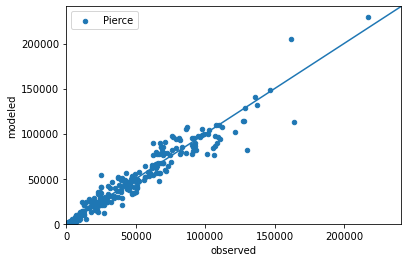

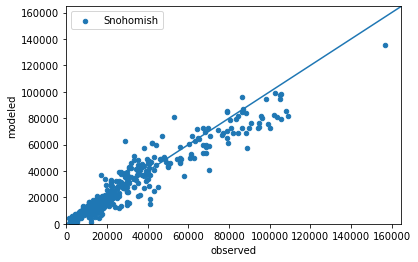

In [8]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [9]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp', 'HOV', 'Arterial', 'Collector'], dtype=object)

r^2 Freeway: 0.9492474001742188


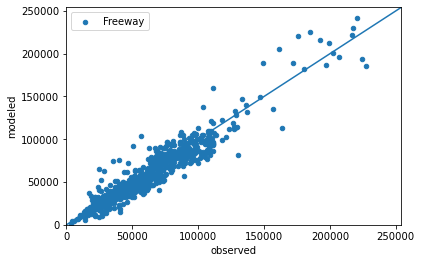

In [10]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

In [11]:
## hourly volumnes

In [12]:
# df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
# ax = df.plot(kind='scatter', x='observed', y='modeled')
# lim = df[['observed','modeled']].max().max()*1.05
# ax.set_ylim(0,lim)
# ax.set_xlim(0,lim)
# x = np.linspace(*ax.get_xlim())
# ax.plot(x, x)
# slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
# print('r^2: ' + str(r_value))

## Screenlines

In [13]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"592,476","498,941",King,"-93,535",-15.8%
1,KENT,"559,335","465,512",King,"-93,823",-16.8%
2,SHIP CANAL,"480,070","493,548",King,"13,478",2.8%
3,SEATTLE - SOUTH OF CBD,"473,322","469,453",King,"-3,869",-0.8%
4,MILL CREEK,"391,447","373,765",King,"-17,682",-4.5%
5,SOUTH BELLEVUE,"389,700","356,618",King,"-33,082",-8.5%
6,KIRKLAND-REDMOND,"381,663","367,976",King,"-13,687",-3.6%
7,SEATTLE - NORTH,"356,051","345,168",King,"-10,883",-3.1%
8,TACOMA - EAST OF CBD,"324,463","334,706",Pierce,"10,243",3.2%
9,PARKLAND,"299,722","272,155",Pierce,"-27,567",-9.2%


r^2 : 0.983530020193849


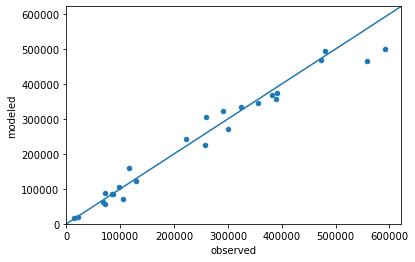

In [14]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))

# External Stations

In [15]:
df = pd.read_csv(os.path.join(csv_path,'external_volumes.csv'))
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,external_station,location,county,observed,modeled,diff,percent_diff
0,3733,I-5 to Olympia,Pierce,"132,000","131,947",-53,-0.0%
1,3744,I-5 to Mount Vernon,Snohomish,"64,400","64,426",26,0.0%
2,3739,I-90 @ Snoqualmie Pass,King,"33,800","33,440",-360,-1.1%
3,3734,SR-507 to Yelm,Pierce,"21,800","22,723",923,4.2%
4,3746,SR-532 to Camano Island,Snohomish,"20,700","20,759",59,0.3%
5,3749,SR-3 to Belfair,Kitsap,"18,400","18,135",-265,-1.4%
6,3748,Hood Canal Bridge,Kitsap,"17,600","17,851",251,1.4%
7,3745,SR-530 N/O Stanwood,Snohomish,"9,100","9,173",73,0.8%
8,3747,Mukilteo-Clinton Ferry,Snohomish,"6,050","5,963",-87,-1.4%
9,3740,SR-2 @ Stevens Pass,King,"4,600","4,571",-29,-0.6%


r^2 : 0.999965007318884


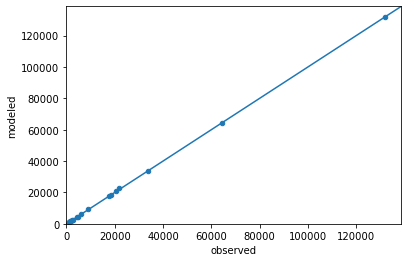

In [16]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))

In [17]:
## External trips/VMT
df_23 = h5py.File(r'..\..\..\..\inputs\model\roster\7to8.h5')
df_23_skims_sov = df_23['Skims']['sov_inc2d'][:]/100
df_23_skims_hov2 = df_23['Skims']['hov2_inc2d'][:]/100
df_23_skims_hov3 = df_23['Skims']['hov3_inc2d'][:]/100

df_results_new = pd.DataFrame()

tod_list = ['5to6', '6to7', '7to8', '8to9', '9to10', '10to14', '14to15', '15to16', '16to17', '17to18', '18to20', '20to5']
for tod in tod_list:
#     print(tod)
    df_temp = pd.DataFrame()
    for mode in ['sov','hov2','hov3']:
#         print(mode)
        od_new = h5py.File(r'..\..\..\..\outputs\supplemental\external_work_'+tod+'.h5', 'r')[mode][:]
        df_temp.loc[tod,mode+'_vmt'] = (df_23_skims_sov*od_new).sum()
        df_temp.loc[tod,mode+'_trips'] = od_new.sum()
        df_temp.loc[tod,mode+'_avg_dist'] = df_temp.loc[tod,mode+'_vmt']/df_temp.loc[tod,mode+'_trips']
    df_results_new = pd.concat([df_results_new, df_temp ])

In [18]:
df_vmt = pd.DataFrame(df_results_new[['sov_vmt','hov2_vmt','hov3_vmt']].sum(),
            columns=['VMT'])
df_vmt.index = [i.split('_')[0].upper() for i in df_vmt.index]

df_trips = pd.DataFrame(df_results_new[['sov_trips','hov2_trips','hov3_trips']].sum(),
            columns=['Trips'])
df_trips.index = [i.split('_')[0].upper() for i in df_trips.index]

df = df_vmt.merge(df_trips, left_index=True, right_index=True)

df.loc['Total',:] = df.sum(axis=0)
df['Avg Distance'] = df['VMT']/df['Trips']
df

,VMT,Trips,Avg Distance
SOV,"7,530,033","237,683",32
HOV2,"572,076","18,264",31
HOV3,"210,948","6,382",33
Total,"8,313,057","262,329",32
